In [48]:
# Load the libraries

import pandas as pd
import numpy as np
import missingno as msno
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Load the Bank Customer data
data = pd.read_csv('german_credit_data.csv')
data.head(7)

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   
5           5   35    male    1    free             NaN              NaN   
6           6   53    male    2     own      quite rich              NaN   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  
5           9055        36            education  
6           2835        24  furniture/equipment

In [40]:
data.shape

(1000, 9)

#### The first row looks like an index we can delete it

In [3]:
data.drop(['Unnamed: 0'], axis = 'columns', inplace = True)

# 1. Missing Value Analysis

<AxesSubplot:>

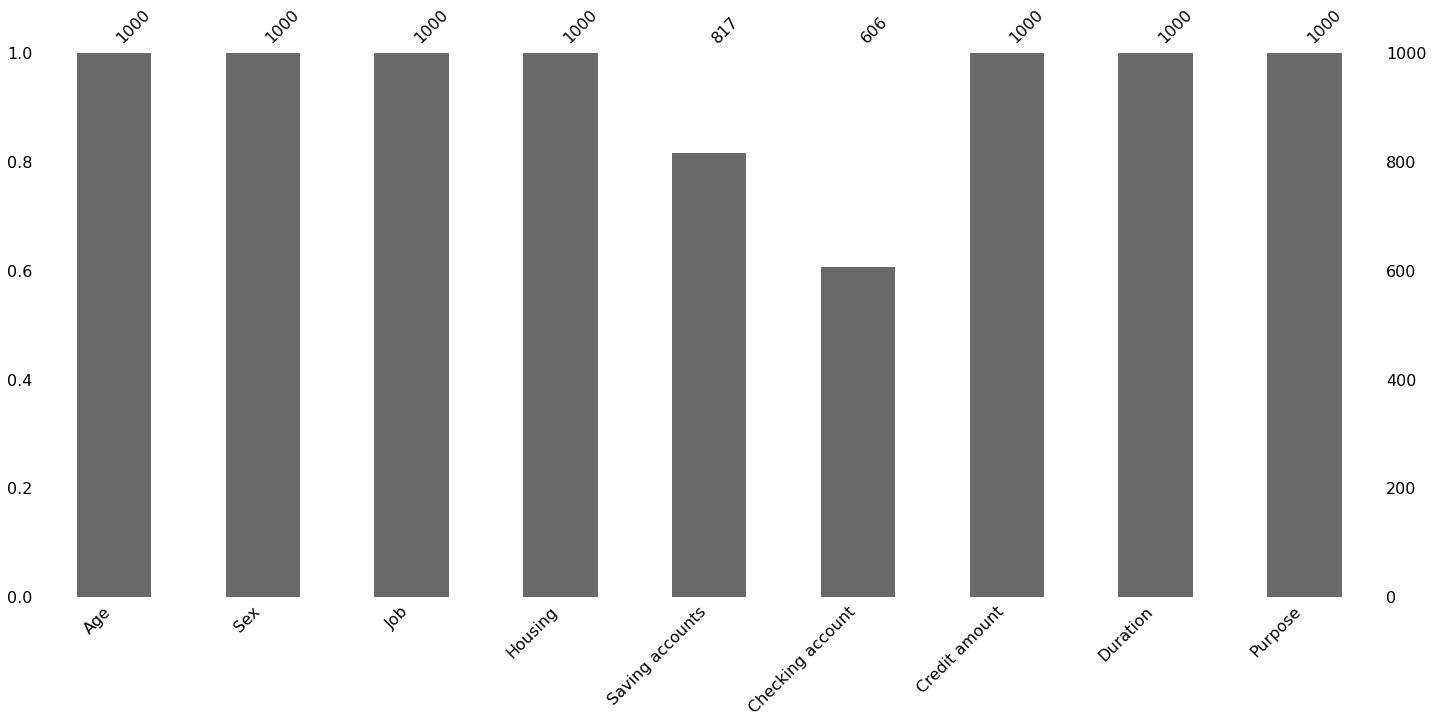

In [4]:
msno.bar(data)

#### We have missing values in Saving Accounts & Checking Accounts

In [5]:
data['Saving accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [6]:
data['Checking account'].value_counts()

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [7]:
data['Job'] = data['Job'].astype('object')


In [8]:
numerical_features = data.select_dtypes(include = np.number)
categorical_features = data.select_dtypes(include = ['object'])

In [9]:
numerical_features

Age  Credit amount  Duration
0     67           1169         6
1     22           5951        48
2     49           2096        12
3     45           7882        42
4     53           4870        24
..   ...            ...       ...
995   31           1736        12
996   40           3857        30
997   38            804        12
998   23           1845        45
999   27           4576        45

[1000 rows x 3 columns]

# 2. Exploratory Data Analysis

In [10]:
fig = px.scatter(data, x = "Age", y = "Credit amount", color = "Sex")
fig['layout'].update(title = ' Age & Credit amount Distribution ')
fig.show()

In [11]:
fig = px.scatter(data, x = "Age", y = "Duration", color = "Sex")
fig['layout'].update(title = ' Age & Duration Distribution ')
fig.show()

In [12]:
fig = px.scatter(data, x = "Credit amount", y = "Duration", color = "Sex")
fig['layout'].update(title = ' Credit Amount & Duration Distribution ')
fig.show()

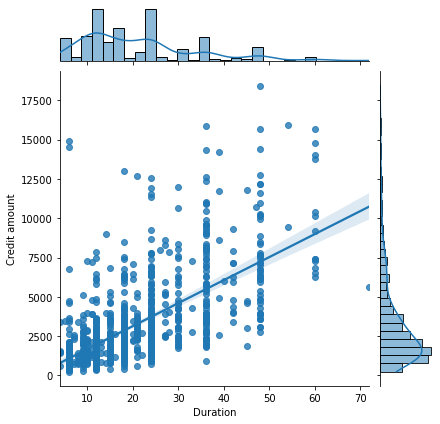

In [13]:
plt1 = sns.jointplot(data = data, x = 'Duration', y = 'Credit amount', kind = 'reg')

#### Some positive correlation between Credit Amount & Duration

<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

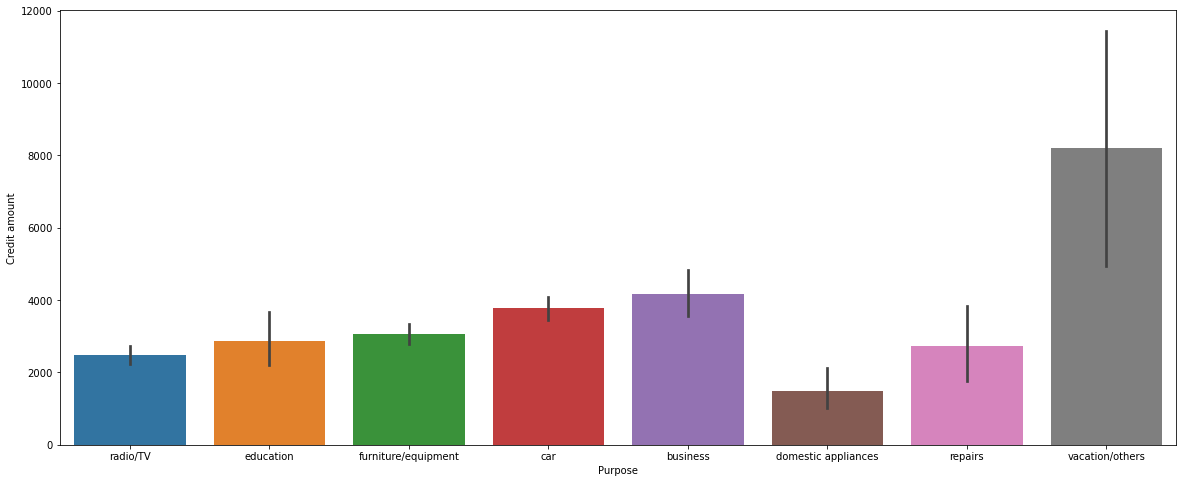

In [14]:
plt.rcParams['figure.figsize'] = (20,8)
sns.barplot(x = data['Purpose'], y = data['Credit amount'])

#### Vacation/Others more credit amount used

<AxesSubplot:xlabel='Purpose', ylabel='count'>

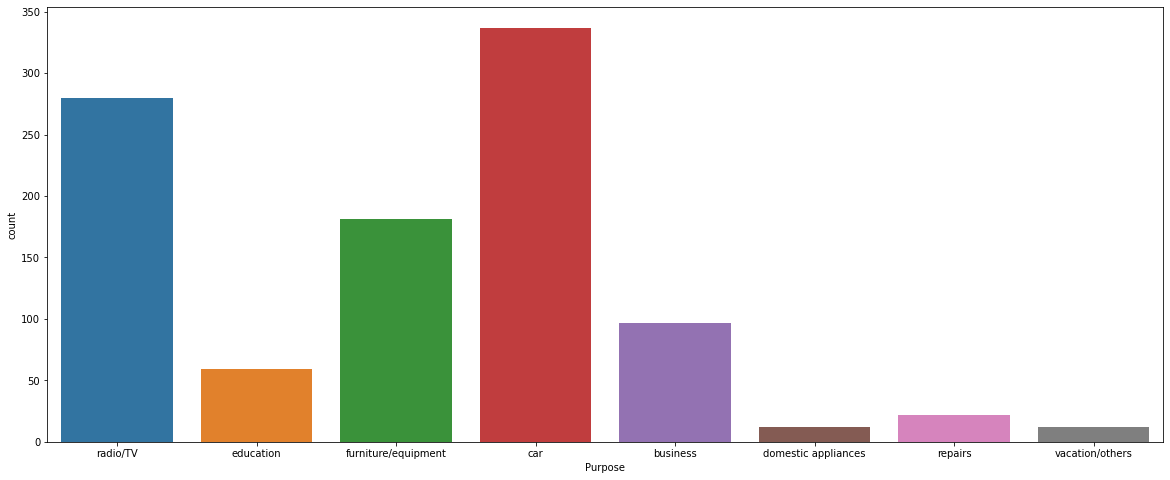

In [15]:
plt.rcParams['figure.figsize'] = (20,8)
sns.countplot(x = data['Purpose'])

#### Most loan amount used for Car/Radio/TV

<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

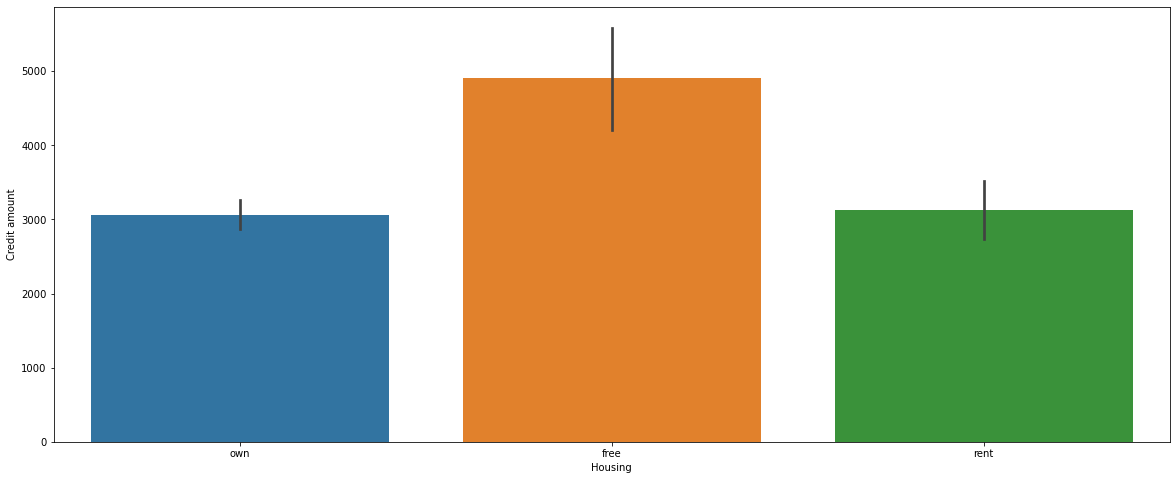

In [16]:
plt.rcParams['figure.figsize'] = (20,8)
sns.barplot(x = data['Housing'], y = data['Credit amount'])

In [17]:
plt.rcParams['figure.figsize'] = (20,8)
df = data['Job'].value_counts()
px.bar(x = df.index, y = df.values)

In [18]:
fig = px.box(data, x="Housing", y="Credit amount", color="Sex")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

#### In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

In [19]:
fig = px.box(data, x="Purpose", y="Credit amount", color="Sex")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

#### The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category.

In [20]:
fig = px.box(data, x="Job", y="Credit amount", color="Sex")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

#### In terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts

<AxesSubplot:xlabel='Age', ylabel='Duration'>

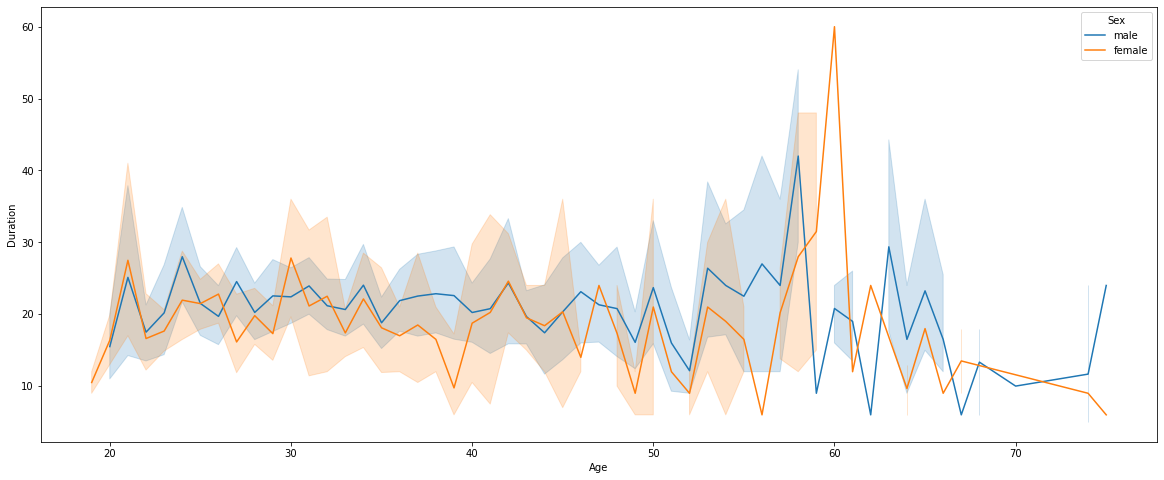

In [21]:
sns.lineplot(data = data, x = 'Age', y = 'Duration', hue = 'Sex')

<AxesSubplot:xlabel='Credit amount', ylabel='Duration'>

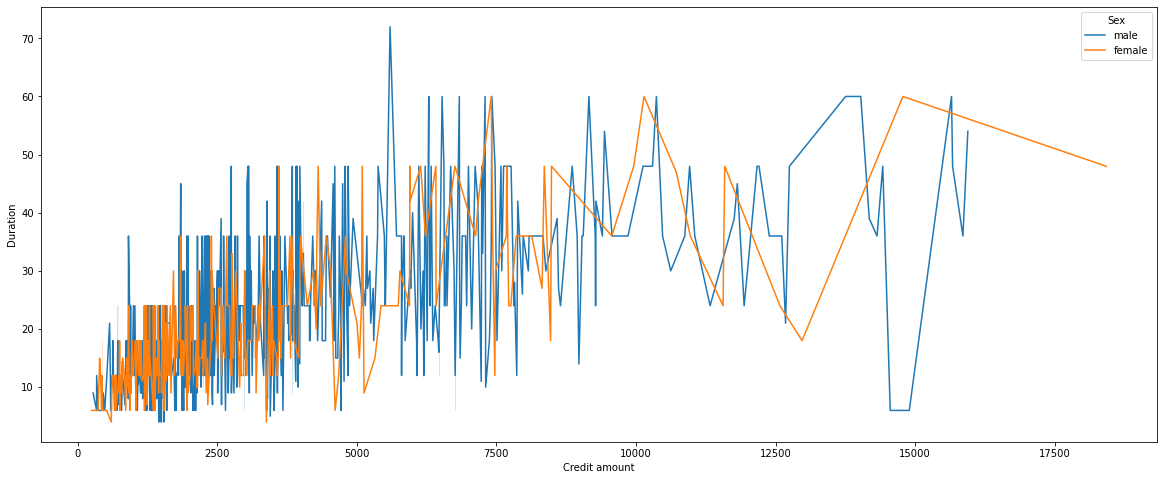

In [22]:
sns.lineplot(data = data, x = 'Credit amount', y = 'Duration', hue = 'Sex')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

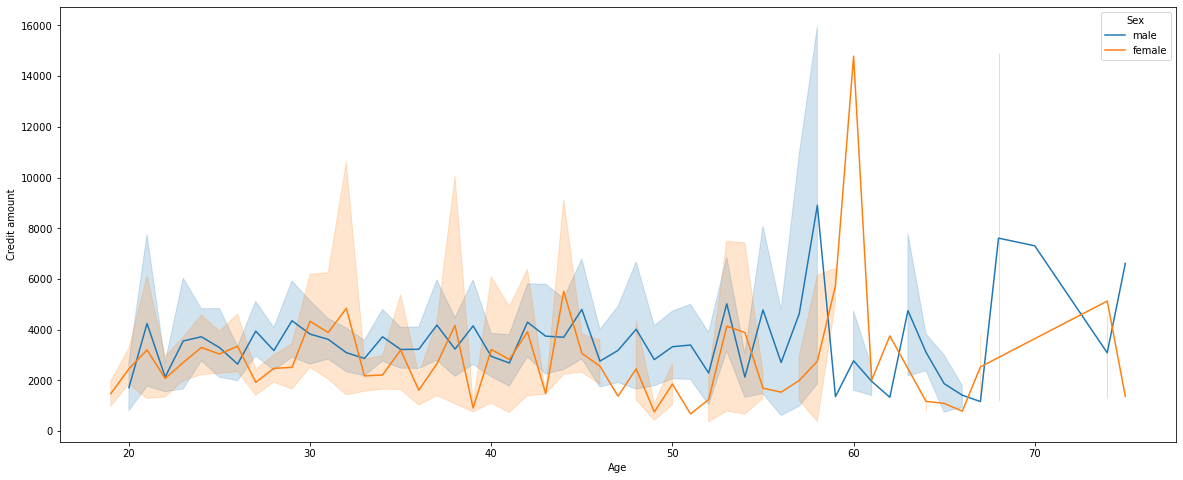

In [23]:
sns.lineplot(data = data, x = 'Age', y = 'Credit amount', hue = 'Sex')

#### There is a linear relationship between Duration and Creadit Amount, Which makes sense because usually, people take bigger credits for longer periods.
#### The trend Between Age and Credit amount is not clear.

# 3. Data Preparation

In [24]:
selected_columns = ['Age','Credit amount', 'Duration']
cluster_data = data.loc[:, selected_columns]

In [79]:
fig = px.histogram(data, x="Age", marginal="box")
fig.show()


fig = px.histogram(data, x="Duration", marginal="box")
fig.show()

fig = px.histogram(data, x="Credit amount", marginal="box")
fig.show()

### We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation

In [84]:
fig = px.histogram(x = np.log(data["Age"]), marginal="box")
fig.show()

fig = px.histogram(x = np.log(data["Duration"]), marginal="box")
fig.show()

fig = px.histogram(x = np.log(data["Credit amount"]), marginal="box")
fig.show()

In [85]:
fig = px.histogram(x = np.log1p(data["Age"]), marginal="box")
fig.show()

fig = px.histogram(x = np.log1p(data["Duration"]), marginal="box")
fig.show()

fig = px.histogram(x = np.log1p(data["Credit amount"]), marginal="box")
fig.show()

In [90]:
fig = px.histogram(x = boxcox(data["Age"])[0], marginal="box")
fig.show()

fig = px.histogram(x = boxcox(data["Duration"])[0], marginal="box")
fig.show()

fig = px.histogram(x = boxcox(data["Credit amount"])[0], marginal="box")
fig.show()

After seeing all the result, the best skew value on all three column provided by log1p, therefore we are going to use log1p Transformation.

In [27]:
cluster_log = pd.DataFrame()
cluster_log['Age'] = np.log1p(cluster_data['Age'])
cluster_log['Credit amount'] = np.log1p(cluster_data['Credit amount'])
cluster_log['Duration'] = np.log1p(cluster_data['Duration'])
cluster_log.head()

Age  Credit amount  Duration
0  4.219508       7.064759  1.945910
1  3.135494       8.691483  3.891820
2  3.912023       7.648263  2.564949
3  3.828641       8.972464  3.761200
4  3.988984       8.491055  3.218876

#### Indeed, the skewness has been eliminated.

The next step will be centering and scaling of variables – it is required by KMeans algorithm. We will use for that a StandardScaler from sklearn library.

In [28]:
sc = StandardScaler()
cluster_scaled = sc.fit_transform(cluster_log)

# 4. Model Training

# 1. KMeans

Text(0.5, 1.0, 'KMeans Cluster ')

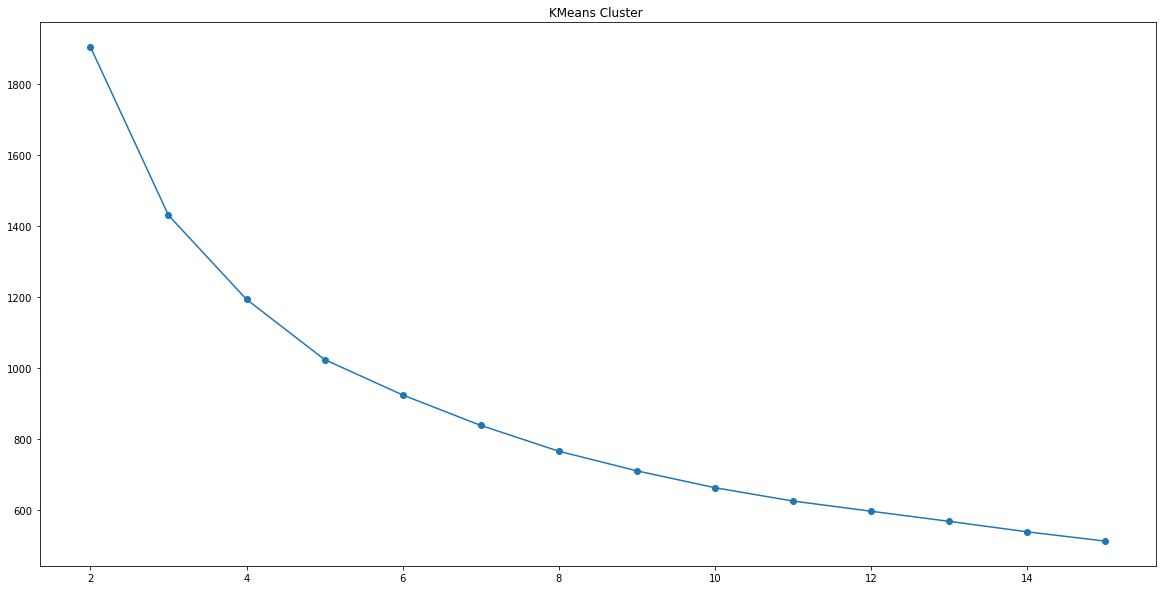

In [29]:
cluster_range = range(2,16)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(cluster_range, wcss, marker = 'o')    
plt.title('KMeans Cluster ')

In [30]:
cluster_range = range(2, 16)
seed_range = range(0, 20)
results = []
for k in cluster_range:
    for seed in seed_range:
        cluster = KMeans(n_clusters = k, random_state = seed)
        cluster_labels = cluster.fit_predict(cluster_scaled)
        silhouette_scores = silhouette_score(cluster_scaled, cluster_labels)
        results.append([k, seed, silhouette_scores])
results = pd.DataFrame(results, columns = ['Clusters','Seed','Score'])        
pivot = pd.pivot_table(results, index = 'Clusters', columns = 'Seed', values = 'Score')        

<AxesSubplot:xlabel='Seed', ylabel='Clusters'>

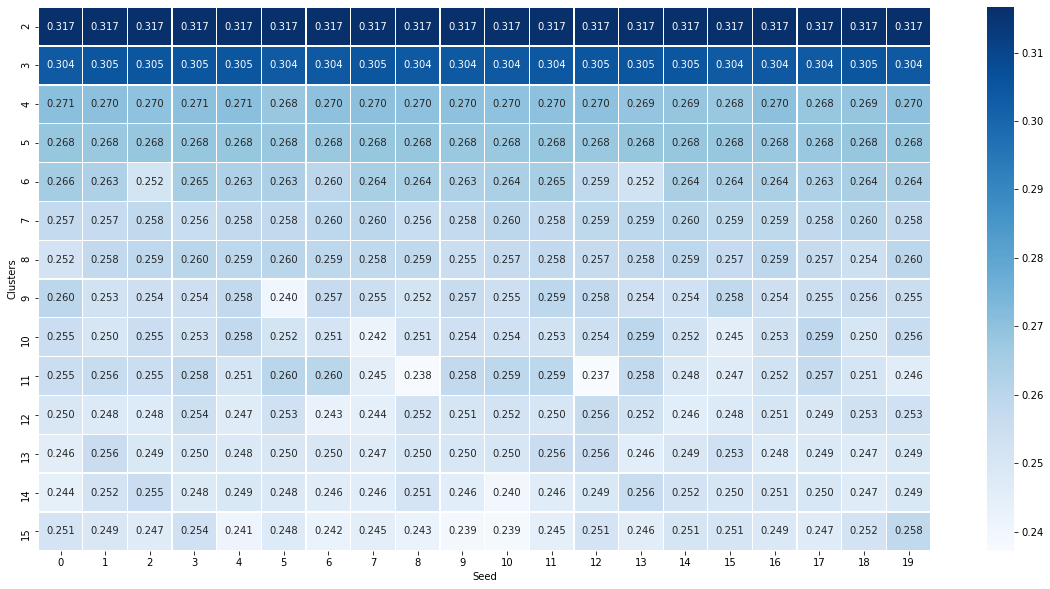

In [31]:
sns.heatmap(pivot, annot = True, cmap = 'Blues', linewidths = 0.3, fmt = '.3f')

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.

I will chose 3 clusters to get more insight into data.

In [32]:
silhouette = []
K = range(3,6)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(cluster_scaled)
    ss = silhouette_score(cluster_scaled, km.labels_, metric='euclidean')
    silhouette.append(ss)
    
pd.DataFrame({'K' : K, 'Silhouette' : silhouette})

K  Silhouette
0  3    0.304123
1  4    0.270454
2  5    0.268458

In [39]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
labels = kmeans.fit_predict(cluster_scaled)
clustered_data = cluster_data.assign(Cluster=labels)

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

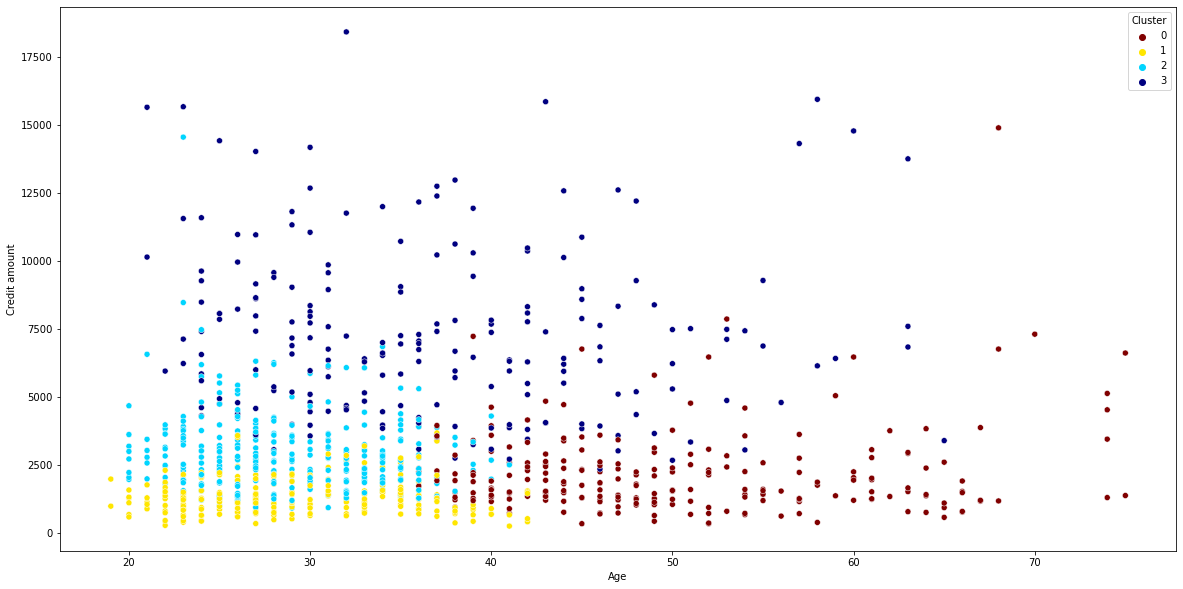

In [34]:
sns.scatterplot(x = clustered_data['Age'], y = clustered_data['Credit amount'], hue = clustered_data['Cluster'], palette="jet_r")

<AxesSubplot:xlabel='Age', ylabel='Duration'>

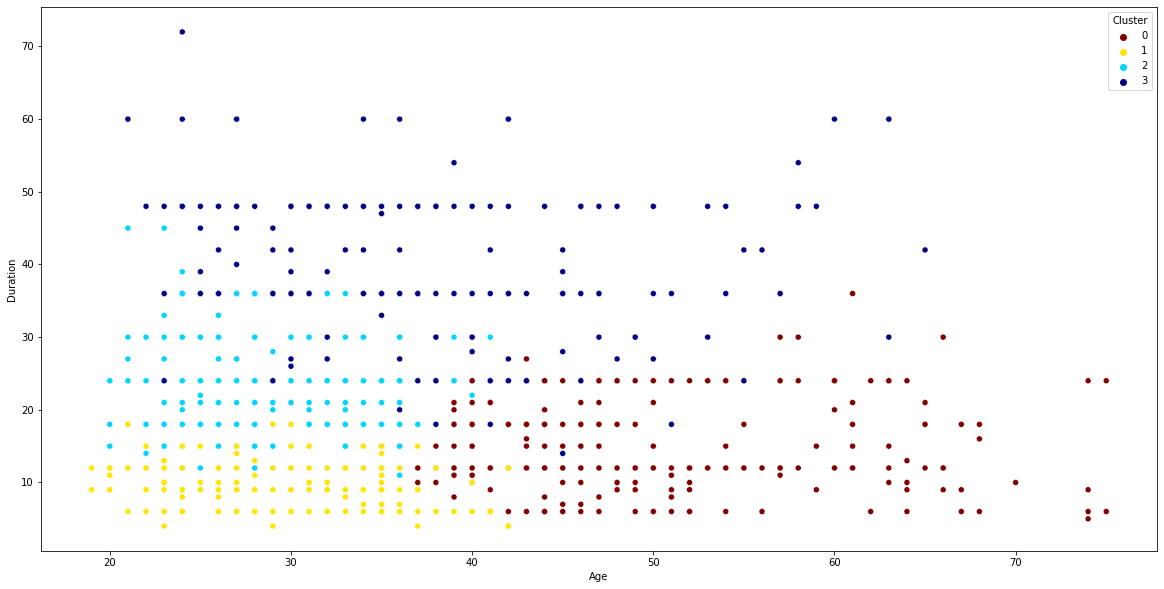

In [35]:
sns.scatterplot(x = clustered_data['Age'], y = clustered_data['Duration'], hue = clustered_data['Cluster'], palette="jet_r")

<AxesSubplot:xlabel='Credit amount', ylabel='Duration'>

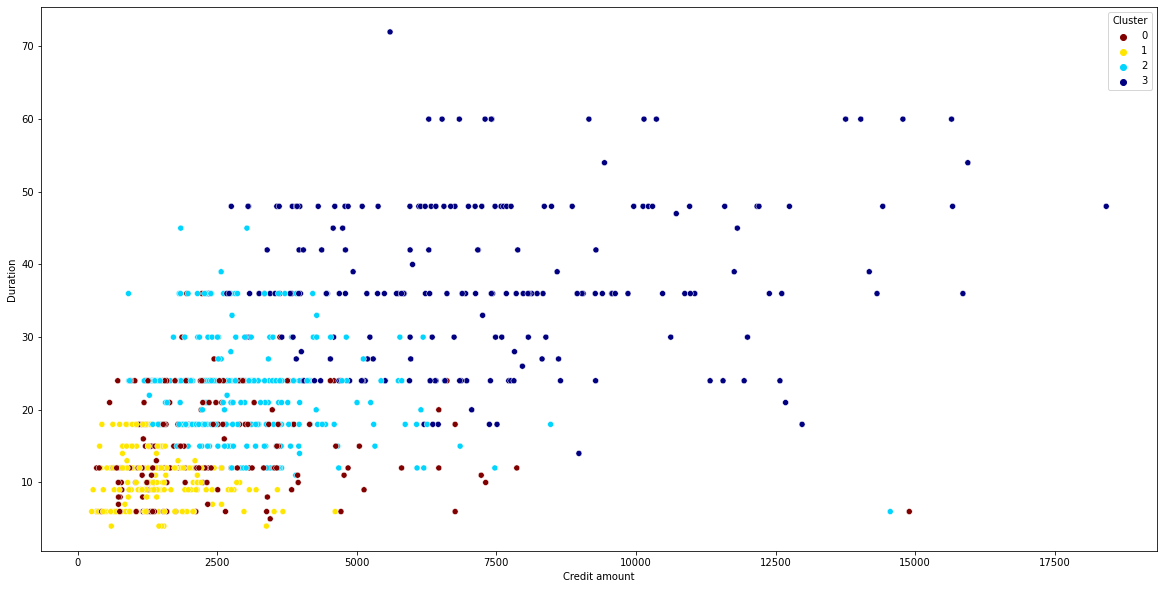

In [36]:
sns.scatterplot(x = clustered_data['Credit amount'], y = clustered_data['Duration'], hue = clustered_data['Cluster'], palette="jet_r")

#### The top 2 cluster shows clear separation but not the last one

In [46]:
fig = px.scatter_3d(clustered_data, x = 'Age', y = 'Duration', z = 'Credit amount', color='Cluster')
fig.show()

In [38]:
clustered_data.groupby(['Cluster']).mean().round()

Age  Credit amount  Duration
Cluster                               
0        50.0         2188.0      15.0
1        29.0         1350.0      11.0
2        29.0         2965.0      23.0
3        37.0         7291.0      38.0

Cluster 0 – high mean of credit amount, long duration, middle-aged customers

Cluster 1 – lower mean of credit amount, short duration, older customers

Cluster 2 - lower mean of credit amount, short duration, young customers

# 2. DBSCAN

In [47]:
dbscan = DBSCAN()
labels = dbscan.fit(cluster_scaled).labels_
clustered_data_dbscan = cluster_data.assign(Cluster=labels)
fig = px.scatter_3d(clustered_data_dbscan, x = 'Age', y = 'Duration', z = 'Credit amount', color='Cluster')
fig.show()

#### From the figure above we can see that DBSCAN is not suitable for this dataset.

# 3. Hierarchical Clustering

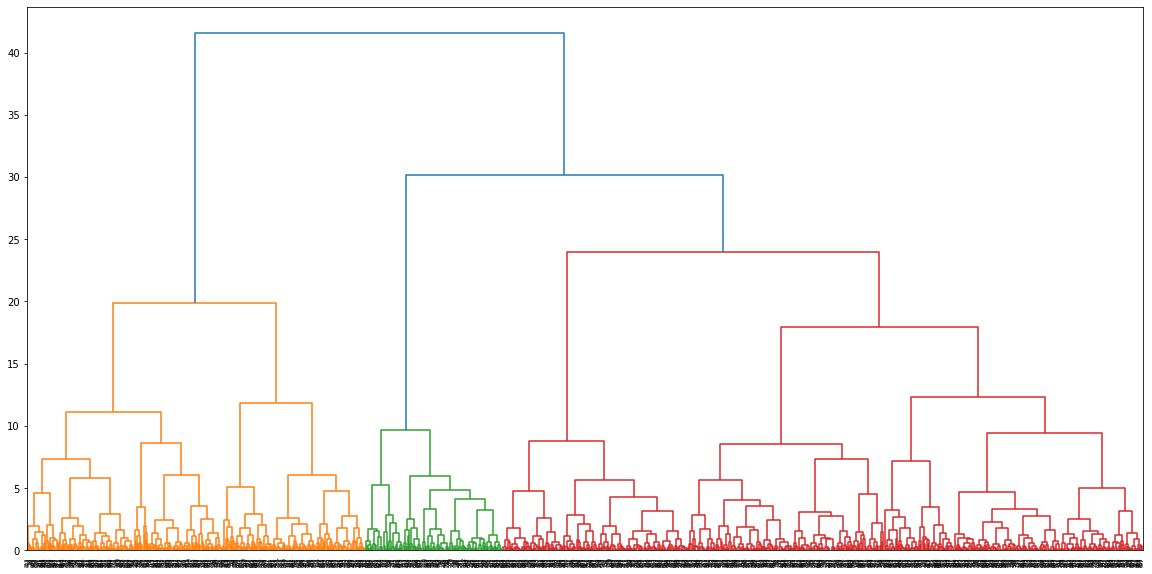

In [52]:
# Dendrogram
plt.figure(figsize=(20,10))
dendrogram = sch.dendrogram(sch.linkage(cluster_scaled, method = 'ward'))

In [65]:
model_agglomerative = AgglomerativeClustering(n_clusters = 4)
labels = model_agglomerative.fit(cluster_scaled).labels_
clustered_data_agglomerative = cluster_data.assign(Cluster=labels)
fig = px.scatter_3d(clustered_data_agglomerative, x = 'Age', y = 'Duration', z = 'Credit amount', color='Cluster')
fig.show()

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

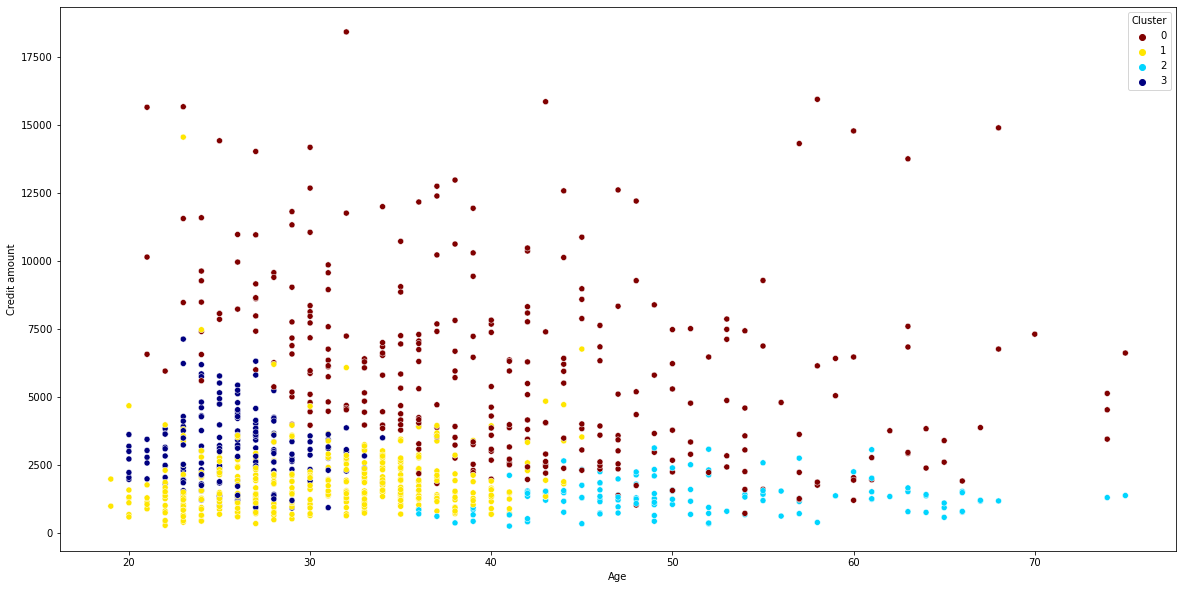

In [66]:
sns.scatterplot(x = clustered_data_agglomerative['Age'], y = clustered_data_agglomerative['Credit amount'], hue = clustered_data_agglomerative['Cluster'], palette="jet_r")

<AxesSubplot:xlabel='Credit amount', ylabel='Duration'>

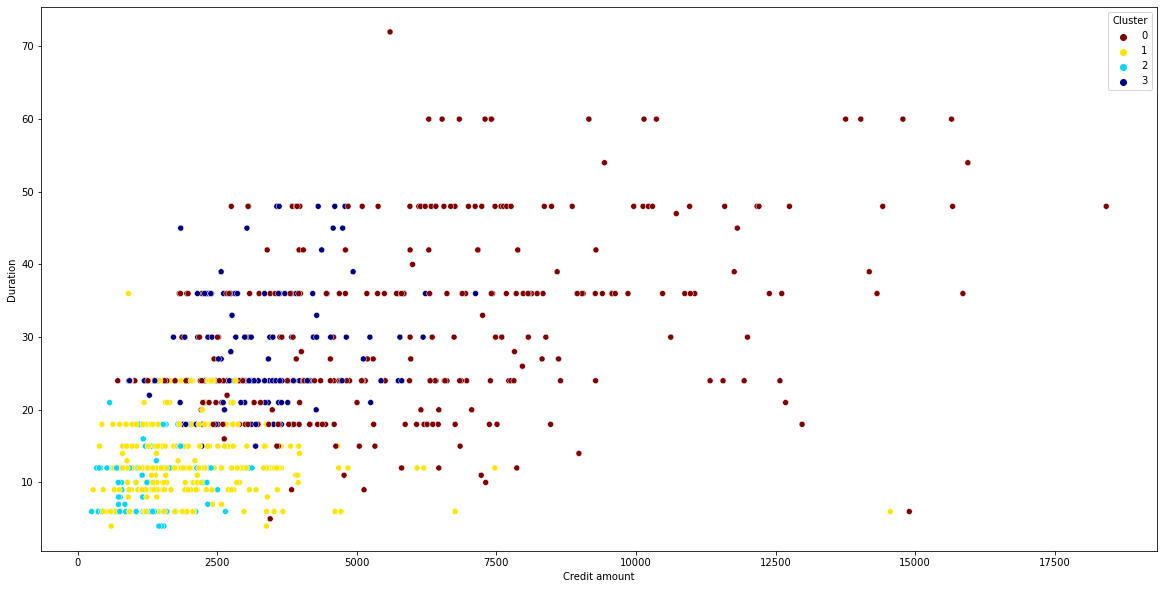

In [67]:
sns.scatterplot(x = clustered_data_agglomerative['Credit amount'], y = clustered_data_agglomerative['Duration'], hue = clustered_data_agglomerative['Cluster'], palette="jet_r")

<AxesSubplot:xlabel='Age', ylabel='Duration'>

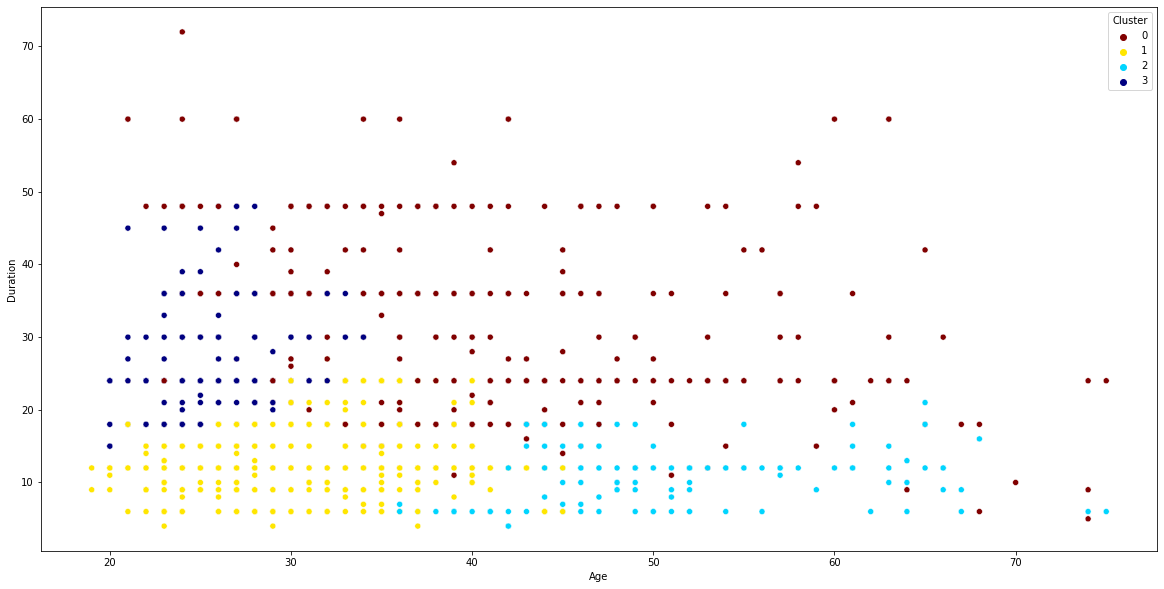

In [68]:
sns.scatterplot(x = clustered_data_agglomerative['Age'], y = clustered_data_agglomerative['Duration'], hue = clustered_data_agglomerative['Cluster'], palette="jet_r")

In [69]:
clustered_data_agglomerative.groupby(['Cluster']).mean().round()

Age  Credit amount  Duration
Cluster                               
0        41.0         6077.0      32.0
1        31.0         1838.0      14.0
2        51.0         1320.0      11.0
3        26.0         3117.0      27.0

The table above shows the centroid of each clusters that could determine the clusters rule. These are:

* Cluster 0 : Higher credit amount, old, long duration customers
* Cluster 1 : Lower credit amount, young, short duration customers
* Cluster 2 : Lower credit amount, old, short duration customers
* Cluster 3 : High credit amount, young, long duration customers